Trying to analyze the double descent of fitted models

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from simple_data import *
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import pickle as pkl

In [5]:
def get_scores(model_type='linear', ns=None, ps=None, num_reps=50, noise_mults=[0.01, 0.1, 0.2]):
    if ns is None:
        ns = [100]
    if ps is None:
        ps = np.concatenate((np.arange(5, 500, 3), [750], [1000], [1500]))
    results_all = {}
    for n in ns:
        for noise_mult in noise_mults:

            results = {}
            train_scores = []
            test_scores = []
            wnorms = []
            pseudo_traces = []
            cov_traces = []
            nuclear_norms = []
            H_traces = []
            for p in tqdm(ps):
                X, y = get_data(2 * n, p, noise_mult=noise_mult)
                
                train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm, H_trace = 0, 0, 0, 0, 0, 0, 0
                num_succeeded_reps = 0
                for reps in range(num_reps):    
                    try:
                        train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=reps, test_size=0.5)
                        model = LinearRegression()
                        model.fit(train_X, train_y)

                        train_pred = model.predict(train_X)
                        train_mse += metrics.mean_squared_error(train_pred, train_y)
                        test_pred = model.predict(test_X)
                        test_mse += metrics.mean_squared_error(test_pred, test_y)    
                        wnorm += np.linalg.norm(model.coef_)
                        cov = train_X.T @ train_X
                        inv = np.linalg.pinv(cov)
                        H = X @ inv @ X.T
                        pseudo_trace += np.trace(inv)
                        cov_trace += np.trace(cov)
                        nuclear_norm += np.linalg.norm(inv, ord='nuc')
                        H_trace += np.trace(H)
                        num_succeeded_reps += 1
                    except:
                        pass
                if num_succeeded_reps == 0:
                    train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm, H_trace = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                train_scores.append(train_mse / num_succeeded_reps)
                test_scores.append(test_mse / num_succeeded_reps)        
                wnorms.append(wnorm / num_succeeded_reps)
                pseudo_traces.append(pseudo_trace / num_succeeded_reps)
                cov_traces.append(cov_trace / num_succeeded_reps)
                nuclear_norms.append(nuclear_norm / num_succeeded_reps)
                H_traces.append(H_trace / num_succeeded_reps)

            train_scores = np.array(train_scores)
            test_scores = np.array(test_scores)
            results = {'ps': np.array(ps), 'ns': np.array(ns), 
                       'train_scores': np.array(train_scores), 'test_scores': np.array(test_scores), 
                       'wnorms': np.array(wnorms), 'pseudo_traces': np.array(pseudo_traces), 
                       'H_traces': np.array(H_traces),
                       'cov_traces': np.array(cov_traces), 'nuclear_norms': np.array(nuclear_norms)}
            results_all[noise_mult] = results
    return results_all

# linear reg in high dim

In [12]:
ns_orig = [250]
ps = np.concatenate((np.arange(25, 200, 5), np.arange(200, 300, 1), np.arange(300, 600, 5))) #, ))
noise_mults = [0.1] #[0.01, 0.1, 0.2]
num_reps = 3
results_all = get_scores(model_type='linear', ns=ns_orig, noise_mults=[0.1], num_reps=num_reps, ps=ps)

100%|██████████| 195/195 [00:44<00:00,  1.21it/s]


/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


num nan 0
num nan 0


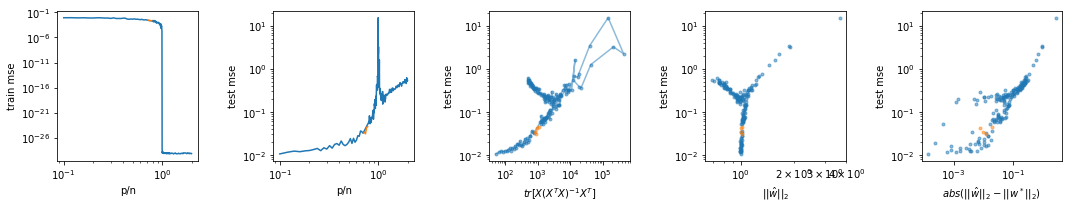

In [13]:
from viz import plot_measures
plot_measures(results_all, noise_mults)

num nan 0
num nan 0


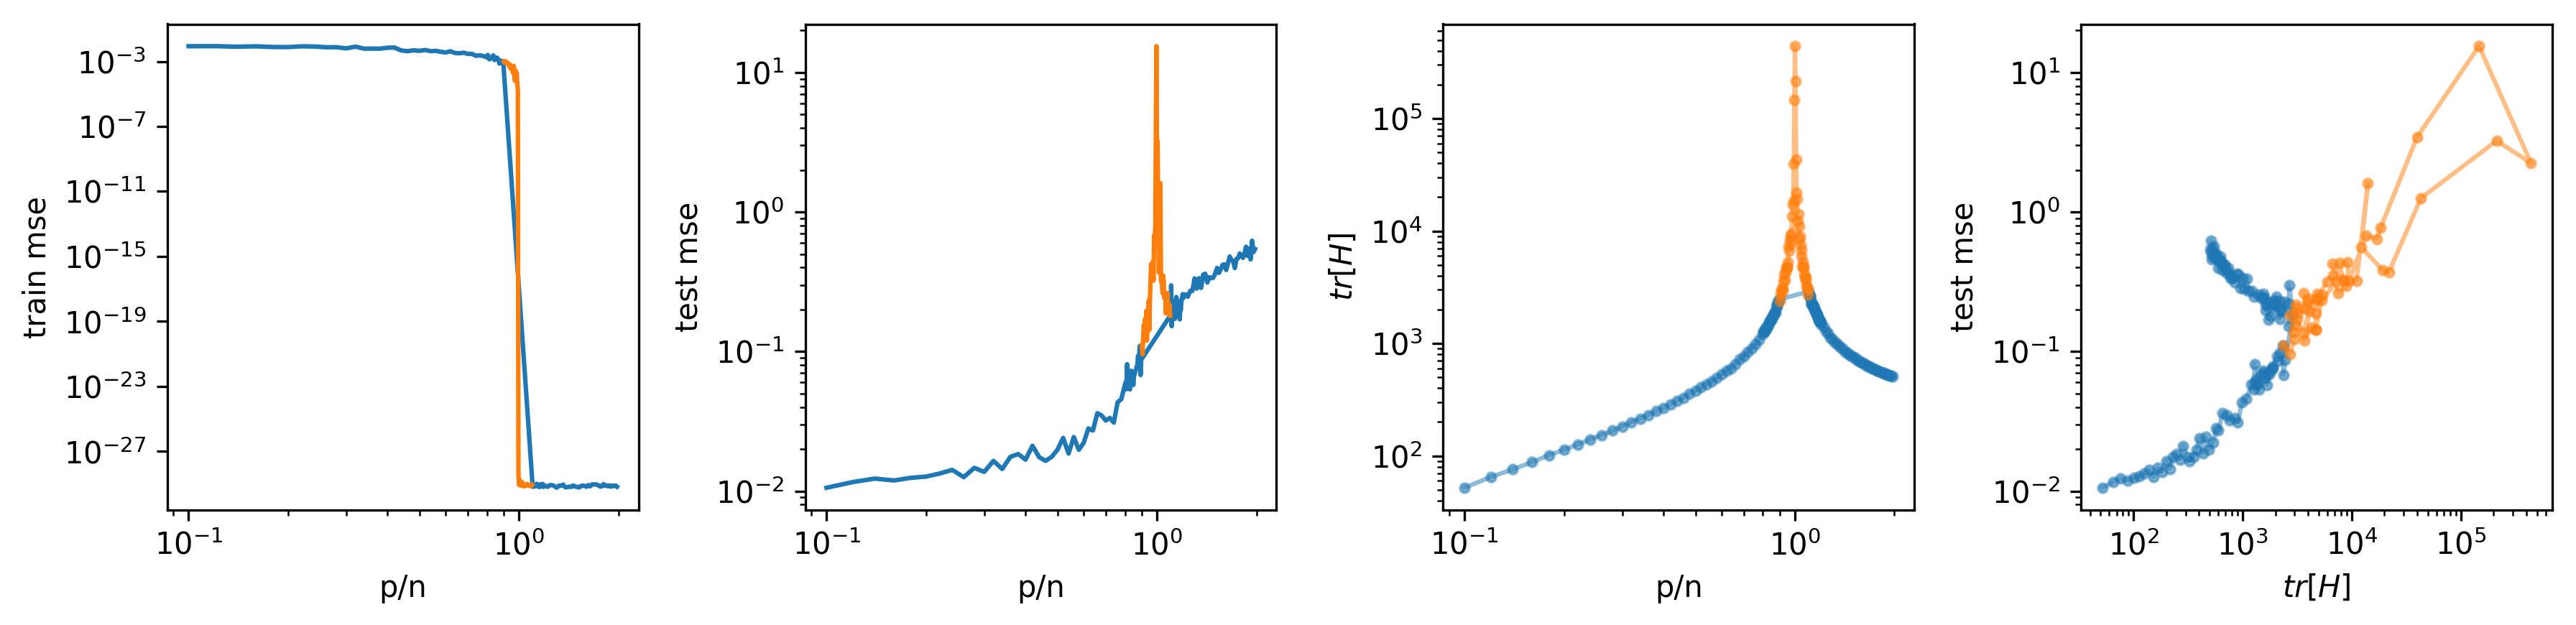

In [18]:
def plot_Htrace(results_all):

    R, C = 1, 5
    plt.figure(figsize=(C * 3, R * 3), dpi=300) #, dpi=300)
    # for n in ns_orig:
    for i, noise_mult in enumerate(noise_mults):
        r = results_all[noise_mult]
        ps, ns, train_scores, test_scores, wnorms, pseudo_traces, cov_traces, nuclear_norms,  H_traces = \
        r['ps'], r['ns'], r['train_scores'], r['test_scores'], np.array(r['wnorms']), np.array(r['pseudo_traces']), np.array(r['cov_traces']), np.array(r['nuclear_norms']), np.array(r['H_traces'])

    #     n = ns_orig[0]
        n = ns[0]
        # select what to paint
        for color in range(2):
            idxs = (np.abs(ps/n - 1) < 0.1)
            if color == 0:
                idxs = ~idxs
#             idxs *= ~np.isnan(train_scores)
            idxs *= (ps/n) < 2

            num_points = ps.size
            plt.subplot(R, C, 1)
            plt.plot((ps / n)[idxs], train_scores[idxs], label=f'noise_mult={noise_mult}')
            plt.xlabel('p/n')
            plt.ylabel('train mse')
            plt.yscale('log')
            plt.xscale('log')
        #     plt.legend()

            plt.subplot(R, C, 2)
            plt.plot((ps / n)[idxs], test_scores[idxs], '-')
            print('num nan', np.sum(np.isnan(test_scores)))
            plt.xlabel('p/n')
            plt.ylabel('test mse')
            plt.yscale('log')
            plt.xscale('log')

            plt.subplot(R, C, 3)
        #     if i == 2:
            plt.plot((ps / n)[idxs], H_traces[idxs], '.-', alpha=0.5) #, c=np.arange(num_points)) #'red')
    #         plt.plot(cov_traces[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')
    #         plt.plot(nuclear_norms[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')    

            plt.xlabel('p/n')
            plt.ylabel('$tr[H]$')
            plt.yscale('log')
            plt.xscale('log')    
            
            plt.subplot(R, C, 4)
        #     if i == 2:
            plt.plot(H_traces[idxs], test_scores[idxs], '.-', alpha=0.5) #, c=np.arange(num_points)) #'red')
    #         plt.plot(cov_traces[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')
    #         plt.plot(nuclear_norms[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')    

            plt.xlabel('$tr[H]$')
            plt.ylabel('test mse')
            plt.yscale('log')
            plt.xscale('log') 

    plt.tight_layout()
    plt.show()
plot_Htrace(results_all)

In [6]:
'''
double_descent_dense.pkl:
ns_orig = [250]
ps = np.concatenate((np.arange(25, 200, 1), np.arange(200, 500, 1), np.arange(500, 1000, 25)))
noise_mults = [0.1] #[0.01, 0.1, 0.2]
num_reps = 25
'''
# pkl.dump(results_all, open('./double_descent_dense.pkl', 'wb'))